<a href="https://colab.research.google.com/github/pidipidi/CS470_IAI_2024_Fall/blob/main/tutorial_2/RL_tutorial_quiz_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Please run this tutorial on Google Chrome.

[https://www.google.com/chrome](https://www.google.com/chrome)


The tutorial may not work properly if you use a browser other than Google Chrome

In [ ]:
#@title Run the following commands to install dependencies
#Install dependencies for OpenAI Gym and Stable-baselines3
!apt install swig cmake &> /dev/null
!pip install stable_baselines3 &> /dev/null
!pip install gymnasium[classic_control] &> /dev/null


#Install dependencies to visualize agents
!apt-get install -y xvfb &> /dev/null
!pip install pyvirtualdisplay scikit-video ffio pyrender &> /dev/null
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
#@title Run the following commands to define visualization tools
import numpy as np
import gymnasium as gym

import skvideo.io
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()
def save_video_of_model(env_name, policy=None, suffix=""):
    """Record an agent behavior in an input environment"""

    env = gym.make(env_name, render_mode="rgb_array")
    obs = env.reset()[0]
    prev_obs = obs

    filename = env_name + suffix + ".mp4"
    output_video = skvideo.io.FFmpegWriter(filename)

    counter = 0
    done = False
    while not done:
        frame = env.render()
        output_video.writeFrame(frame)

        input_obs = obs

        if policy is not None:
            action = policy(input_obs)

        else:
            action = env.action_space.sample()

        if "FrozenLake" in env_name:
            action = action.item()
        prev_obs = obs

        obs, reward, done, _, info = env.step(action)
        counter += 1

    output_video.close()
    print("Successfully saved {} frames into {}!".format(counter, filename))
    return filename

def play_video(filename, width=None):
    """Play the filename of video"""
    from IPython.display import HTML
    from base64 import b64encode

    mp4 = open(filename,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    source = """
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url
    return source

import torch
import random
import os

def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    # pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

my_seed = 42
my_seed_everywhere(my_seed)

# CartPole-v0 environment

In this quiz, we will use CartPole-v0 environment. This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in “Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem”. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

https://gymnasium.farama.org/environments/classic_control/cart_pole/

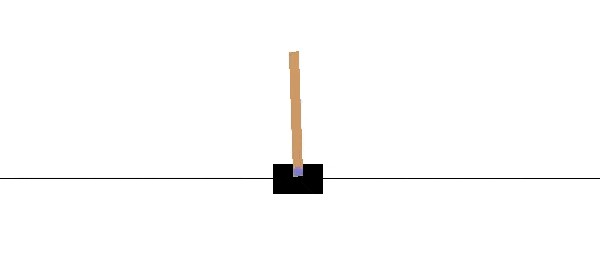

# 1. Please choose the pair that properly describes the class of (observation_space, action_space) of "CartPole-v1".



1.   (Discrete, Discrete)
2.   (Box, Discrete)
3.   (Discrete, Box)
4.   (Box, Box)


You may use the cell below to find the answer

In [ ]:
import gymnasium as gym

env = gym.make("CartPole-v1")

#print( env.? )
#print( env.? )

# 2. Please choose the pair that properly fills in the sentence.

We use {$\qquad$} method to initialize or restart the environment. If we initialize "CartPole-v1" environment, the **first** element of the initial state fall within {$\qquad$} range.


1.   (step, [-1.0, 1.0])
2.   (reset, [-0.05, 0.05])
3.   (reset, [-4.8, 4.8])
4.   (step, [-0.05, 0.05])


You may use the cell below to find the answer

In [ ]:
import gymnasium as gym

env = gym.make("CartPole-v0")

#print(env.?)

# 3. Please choose the answer that correctly estimates the maximum total reward of "CartPole-v1" environment.


1.   around 110
2.   around 250
3.   around 470
4.   around 700


You may use the cell below to find the answer.

You may increase (decrease) the total_timestep value if you think the agent has not trained enough (has trained enough).

In [ ]:
import stable_baselines3
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.evaluation import evaluate_policy

######################################################################
##  You can choose your Algorithm / Environment / seed as you want  ##
######################################################################

policy_cls = PPO
env_id = "CartPole-v1"
SEED = 47

######################################################################
######################################################################


# Use a separate environement for evaluation
env = gym.make(env_id)
eval_env = gym.make(env_id)
# Initialize Agent, which is currently an random Agent, before training
model = policy_cls(policy='MlpPolicy',      # For vision-based RL, we use 'CnnPolicy'
            env=env,
            seed=SEED,
            gamma=0.9)

In [ ]:
from stable_baselines3.common.callbacks import CheckpointCallback, EveryNTimesteps, EvalCallback

rewards = []
class CB(EvalCallback):
    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            mean_reward, std_reward = evaluate_policy(self.model, self.eval_env, n_eval_episodes=5)
            rewards.append(mean_reward)
            print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")
        return True

cb = CB(eval_env=eval_env, eval_freq=10000)
model.learn(total_timesteps=100000, callback=cb)


In [ ]:
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

In [ ]:
env = gym.make(env_id, render_mode="rgb_array")
obs = env.reset()[0]
prev_obs = obs

policy=lambda *x: model.predict(*x)[0]

counter = 0
done = False
while not done:
    frame = env.render()
    input_obs = obs

    if policy is not None:
        action = policy(input_obs)

    else:
        action = env.action_space.sample()

    if "FrozenLake" in env_id:
        action = action.item()
    prev_obs = obs

    obs, reward, done, _, info = env.step(action)
    counter += 1

In [ ]:
save_video_of_model(env_id, policy=lambda *x: model.predict(*x)[0])

from IPython.display import HTML
source = play_video(filename=f'{env_id}.mp4')
HTML(source)